# Clustermap's results with kde boundaries

We will use BY1 as an example but it can be replaced with any other result.
This notebook is for generating the cell mask.
Once the cell mask is generated and saved, see results_fig.py to generate the final figure.

In [3]:
!pip install opencv-python

In [4]:
import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import gaussian_kde
from itertools import product
import random
from anndata import AnnData
from skimage.morphology import convex_hull_image
from skimage import io
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import tifffile

warnings.filterwarnings('ignore')
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.18.4 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


### Loading BY1 results

I used the results with dapi points in order to have cleaner shapes

In [5]:
spots = pd.read_csv('C:/Users/yhe/Desktop/BY1DAPI_spot_meta.csv')
spots

,spot_location_1,spot_location_2,spot_gene_id,spot_image_position,spot_cell_id
0,3,1739,0.0,BY1,934.0
1,3,1744,0.0,BY1,934.0
2,3,1749,0.0,BY1,934.0
3,3,1754,0.0,BY1,934.0
4,3,1759,0.0,BY1,934.0
...,...,...,...,...,...
717627,9422,5294,222.0,BY1,226.0
717628,9453,5303,118.0,BY1,226.0
717629,9490,5349,697.0,BY1,226.0
717630,9492,5146,972.0,BY1,166.0


In [6]:
# for BY1 the last row had NaN values
spots.dropna(inplace=True)
spots

,spot_location_1,spot_location_2,spot_gene_id,spot_image_position,spot_cell_id
0,3,1739,0.0,BY1,934.0
1,3,1744,0.0,BY1,934.0
2,3,1749,0.0,BY1,934.0
3,3,1754,0.0,BY1,934.0
4,3,1759,0.0,BY1,934.0
...,...,...,...,...,...
717626,9395,5353,970.0,BY1,1303.0
717627,9422,5294,222.0,BY1,226.0
717628,9453,5303,118.0,BY1,226.0
717629,9490,5349,697.0,BY1,226.0


### A few functions

In [7]:
def remove_outliers(spots, labels, k=20):
    '''
    We remove the cells that have less than k spots
    param : spots (DataFrame with results)
            labels (the different cell labels)
            k : threshold on the cell size (if the number of spots to have cell label x < k, we consider them
                as outliers)
    '''
    good_labels = []
    for x in labels:
        if spots.loc[spots['spot_cell_id']==x, ['spot_location_1']].shape[0]<k:
            continue
        else:
            good_labels += [int(x)]
    return(good_labels)

In [8]:
def get_mask_thresh(array, data, contours_levels):
    '''
    Select the best contour threshold to compute the cell mask
    param : 
            - array : the binary array where 1 values denote the presence of spot from the cell
            - data : pcolormesh with the different values from the kde (np array)
            - contours_levels : the different levels of contours threshold
    '''
    contours_inv = contours_levels[::-1]
    data_current = (data>contours_inv[1]).astype(float)
    data_next = (data>contours_inv[2]).astype(float)
    # start at 1 because we know that there is not many points above the max value
    i = 1
    array_current = data_current*array
    array_next = data_next*array
    while np.sum(array_next)-np.sum(array_current)>= 5 and i<len(contours_levels)-2:
        i += 1
        data_current = data > contours_inv[i]
        data_next = data > contours_inv[i+1]
        array_current = data_current*array
        array_next = data_next*array
    return(np.transpose(data_current))
            
            
        

In [9]:
def smooth_boundaries_thresh(labels_list, spots, plot=False):
    mask_kde = np.zeros((np.amax(spots['spot_location_2'])+1, np.amax(spots['spot_location_1'])+1))
    for label in labels_list:
               
        spots_cell = spots.loc[spots['spot_cell_id']==label, ['spot_location_1', 'spot_location_2']]
        # we extract tuples of X an Y where we have a sample that has the label
        cell = np.array(spots_cell).T
        x,y = cell
        x_range = x.max() - x.min()
        y_range = y.max() - y.min()
        # we initialize a kernel density estimation (gaussian) for estimation based on the samples
        k = gaussian_kde(cell)
        xi,yi = np.mgrid[x.min():x.max()+1, y.min():y.max()+1]
        zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)   
        p_data = plt.pcolormesh(xi, yi, zi, shading='gouraud', cmap='BuGn_r').get_array().reshape(xi.shape).astype(float)
        contours_data = plt.contour(xi,yi,zi).levels
        spots_array_bis = np.zeros((x_range+1, y_range+1))
        for i in range(len(x)):
            spots_array_bis[x[i]-x.min(), y[i]-y.min()] = 1
        mask = get_mask_thresh(spots_array_bis, p_data, contours_data)
        mask_labelled = label*mask
        for y_ind,x_ind in product(range(y.min(), y.max()+1), range(x.min(), x.max()+1)):
            mask_kde[y_ind,x_ind] = max(mask_kde[y_ind,x_ind], mask_labelled[y_ind-y.min(),x_ind-x.min()])
                
        
        if plot:
            fig,axes = plt.subplots(ncols=5, nrows=1, figsize=(40,8))
            plt.rc('axes', titlesize=25) #fontsize of the title
            axes[0].plot(x,y,'ko')
            axes[0].set_title('Scatter plot')
            axes[0].axis('off')
            axes[1].pcolormesh(xi,yi,zi, shading='auto', cmap='BuGn_r')
            axes[1].set_title('Gaussian KDE')
            axes[1].axis('off')
            axes[2].pcolormesh(xi,yi,zi, shading='gouraud', cmap='BuGn_r')
            axes[2].set_title('Density with gouraud shading')
            axes[2].axis('off')
            axes[3].pcolormesh(xi, yi, zi, shading='gouraud', cmap='BuGn_r')
            axes[3].contour(xi,yi,zi)
            axes[3].set_title('Contours')
            axes[3].axis('off')
            axes[4].imshow(mask.astype(float), origin='lower')
            axes[4].set_title('Results (Adaptive threshold)')
            axes[4].axis('off')
            plt.show()
    return(mask_kde)

### 1. First step : generate the mask

This part may take some time

In [10]:
# cell labels : 0 does not correspond to a cell for by1 so we will keep the labels only from 1
labels = np.unique(spots['spot_cell_id']).astype(int)[1:]

In [11]:
labels_good = remove_outliers(spots, labels)

In [12]:
print(f'We kept {len(labels_good)} cells over {labels.shape[0]}')

We kept 1455 cells over 1570


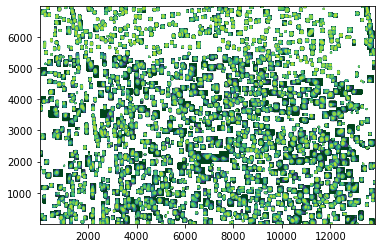

In [13]:
mask = smooth_boundaries_thresh(labels_good, spots)

In [14]:
# to save the mask as tifffile
tifffile.imsave('mask_by1.tif', mask)

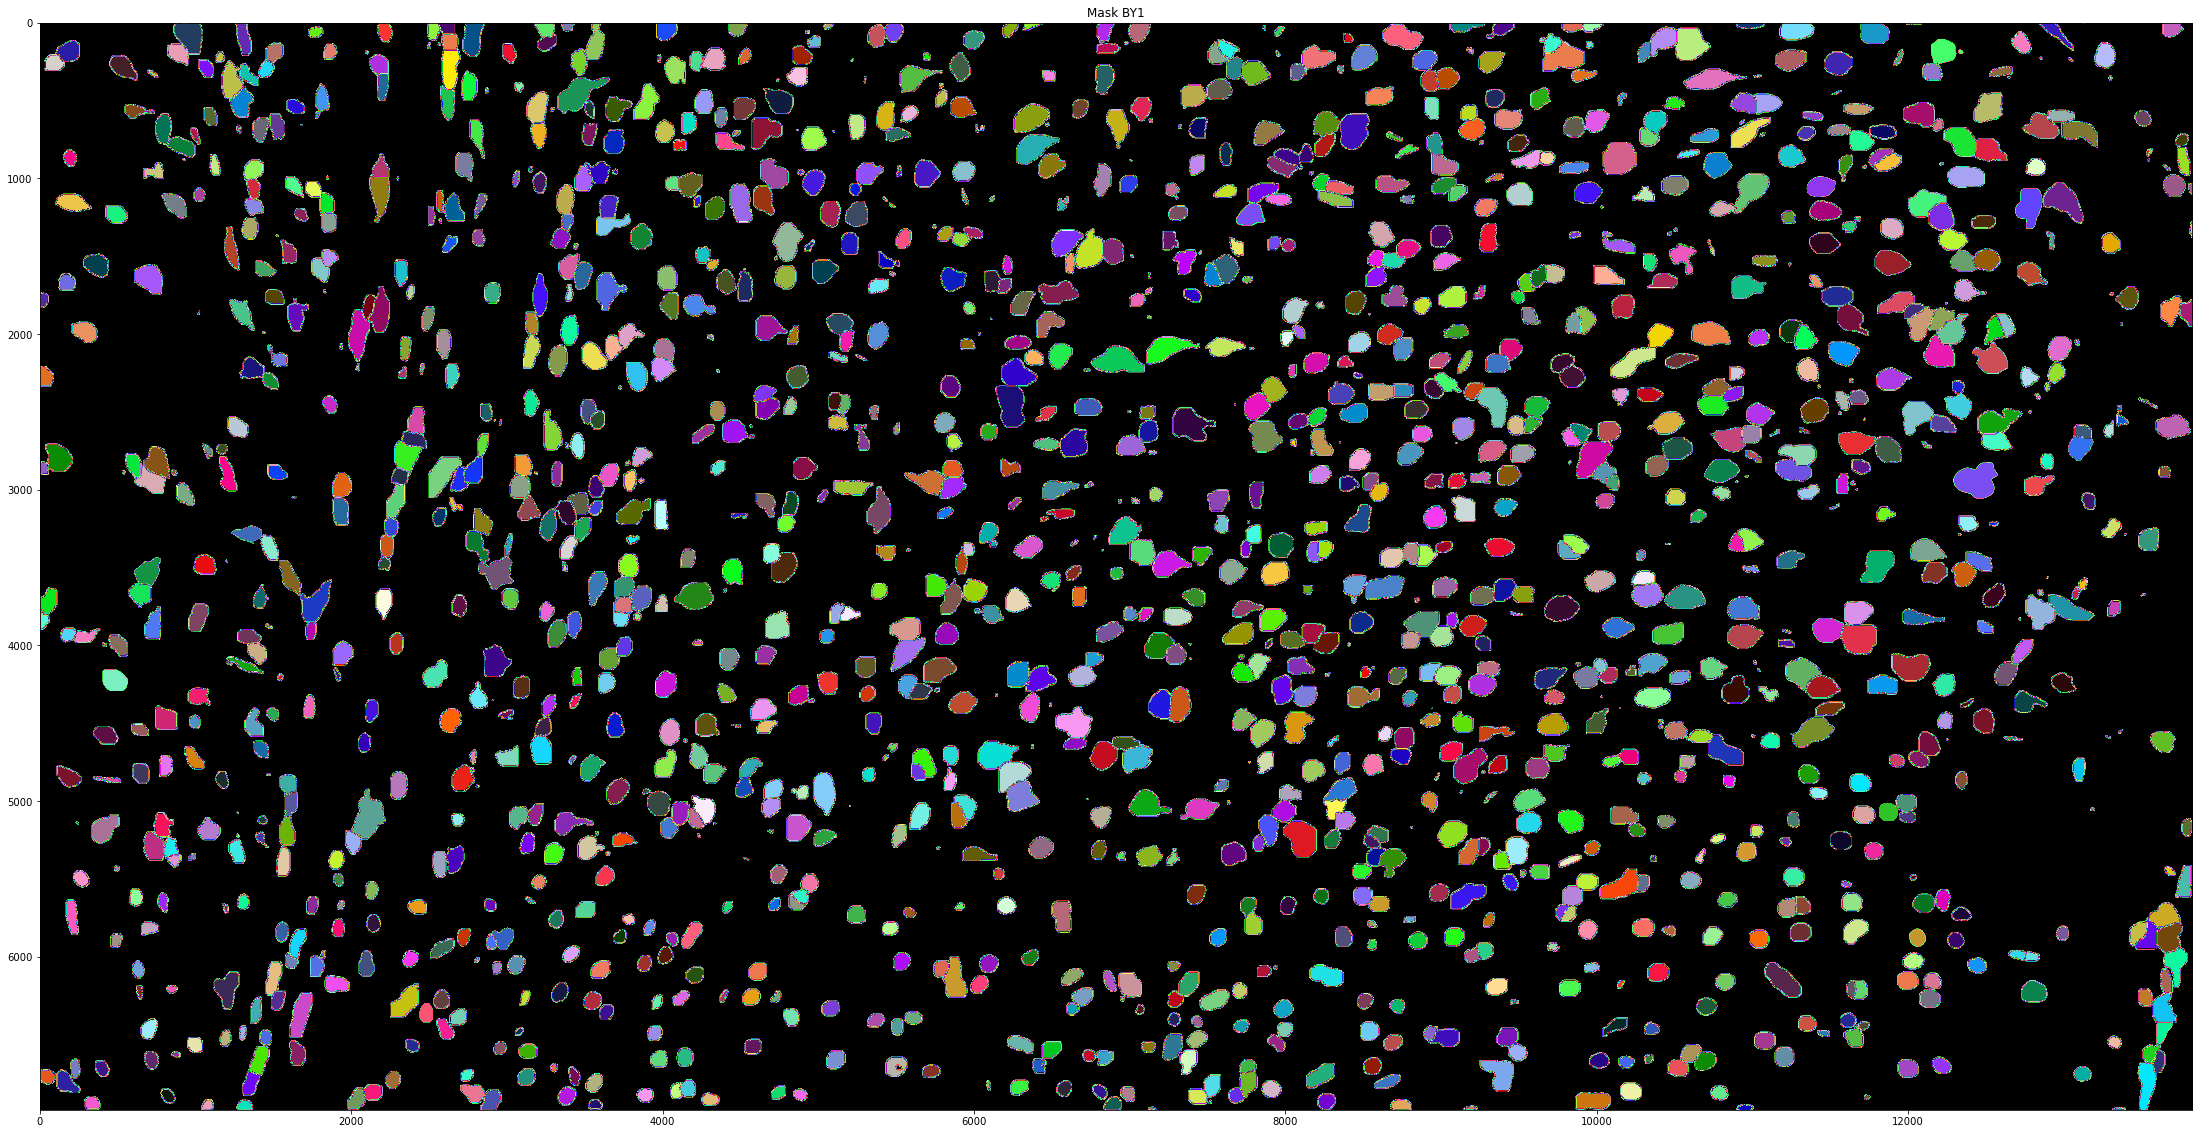

In [15]:
cmap = ListedColormap(['#000000']+["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                    for k in range(len(labels_good)-1)])
plt.figure(figsize=(40,20))
plt.imshow(mask, cmap=cmap)
plt.title('Mask BY1')
plt.show()

In [ ]:
# Sanity check
mask_test = tifffile.imread('mask_by1.tif')
False in (mask_test == mask)

False